In [2]:
using DelaySSAToolkit, Catalyst, DifferentialEquations, Plots, Latexify, StatsBase, LinearAlgebra

# Initiation time distribution

## Model reactions

In [3]:
# three-state process that accounts for the binding of RNAP

initiation = @reaction_network begin
    (k₁₂,k₂₁), S₁ <--> S₂
    (k₂₃,k₃₂), S₂ <--> S₃
    k₃₁, S₃ --> S₁
    k₃, S₃ --> ∅
end k₁₂ k₂₁ k₂₃ k₃₂ k₃₁ k₃;

In [5]:
# check species

Catalyst.species(initiation)

3-element Vector{Any}:
 S₁(t)
 S₂(t)
 S₃(t)

In [6]:
# check reactions

Catalyst.reactions(initiation)

6-element Vector{Reaction}:
 k₁₂, S₁ --> S₂
 k₂₁, S₂ --> S₁
 k₂₃, S₂ --> S₃
 k₃₂, S₃ --> S₂
 k₃₁, S₃ --> S₁
 k₃, S₃ --> ∅

## Model parameters

In [53]:
# set parameter values [1/min]
# from the paper Distinguishing between models of mammalian gene expression: telegraphlike models versus mechanistic models
k₁₂ = 0.032*60;
k₂₁ = 0.032*60;
k₂₃ = 0.16*60;
k₃₂ = 0.016*60;
k₃₁ = 0.032*60;
k₃ = 0.32*60;

## Stochastic simulations

In [54]:
# set model parameters
p = (k₁₂,k₂₁,k₂₃,k₃₂,k₃₁,k₃);

# set initial conditions
u₀ = [0,1,0];

# set time interval to solve on
ts =50.0;
tspan = (0.0,ts);

# define discrete problem
dprob = DiscreteProblem(u₀, tspan, p);

# define jump problem
jprob = JumpProblem(initiation, dprob, Direct())

# number of trajectories
ntraj = 10^6

# run SSA for multiple trajectories
ensprob = EnsembleProblem(jprob)
@time ens = solve(ensprob, SSAStepper(), EnsembleThreads(), trajectories=ntraj);

 17.656888 seconds (15.86 M allocations: 2.798 GiB, 77.88% gc time)


In [55]:
# get waiting times from individual trajectories
wtimes = [ens[n].t[end-1] for n=range(1,ntraj)]
mu = mean(wtimes)
println("Mean initiation time [min] = ",mu)
maxwt = maximum(wtimes)
print("Maximum initiation time [min] = ",maxwt)

Mean initiation time [min] = 0.3433949233467566
Maximum initiation time [min] = 9.481888671793282

In [56]:
# get the initiation time distribution f(t)
hwt = fit(Histogram, wtimes, closed=:left, 0:0.002:10.0)
hwtnorm = normalize(hwt,mode=:pdf)

Histogram{Float64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  0.0:0.002:10.0
weights: [0.185, 0.5485, 0.848, 1.13, 1.439, 1.7055, 1.944, 2.2005, 2.3845, 2.545  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
closed: left
isdensity: true

In [57]:
# export initiation time distribution to a table
using CSV
using DataFrames
wtSSA = DataFrame(t=hwtnorm.edges[1][1:end-1],f=hwtnorm.weights);

In [59]:
# export the table to a file
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="wt-dist-model-2-SSA.csv"

CSV.write(string(directory,"\\",filename), wtSSA, writeheader=false)

"C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal\\wt-dist-model-2-SSA.csv"

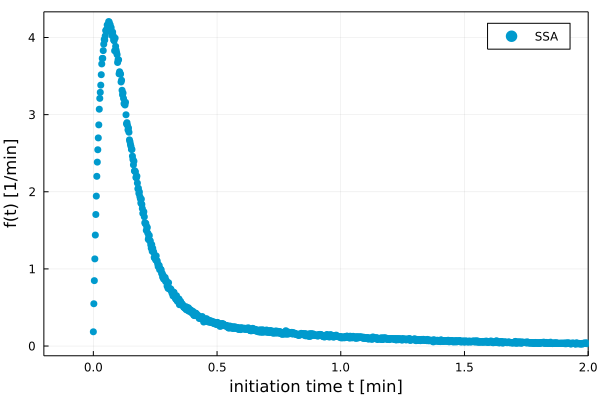

In [58]:
# plot the waiting time distributions

fig1=plot(wtSSA[!,1],wtSSA[!,2],
    seriestype=:scatter,
    xlims=(-0.2,2),
    xlabel="initiation time t [min]",
    ylabel="f(t) [1/min]",
    framestyle=:box,
    color="deepskyblue3",
    markerstrokecolor="deepskyblue3",
    label="SSA")

In [33]:
# import exact data obtained by Mathematica

using CSV
using DataFrames
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="wt-dist-model-2-exact.csv"

wtexact = CSV.read(string(directory,"\\",filename), DataFrame, header=false);

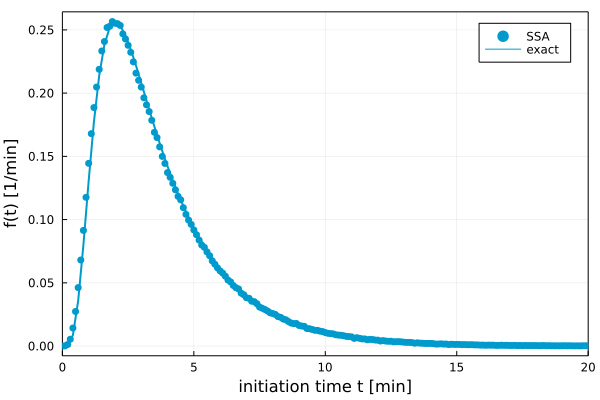

In [34]:
# add exact values to the plot

plot!(wtexact[!,1],wtexact[!,2],xlim=(0,20),line=2,color="deepskyblue3",label="exact")

In [ ]:
# export figure

# savefig(fig1, "wt-dist-model-2.pdf")

# Transcription model

## Model reactions

In [98]:
transcription = @reaction_network begin
    (k₁₂,k₂₁), S₁ <--> S₂
    (k₂₃,k₃₂), S₂ <--> S₃
    k₃₁, S₃ --> S₁
    k₃, S₃ --> S₂ + N
end k₁₂ k₂₁ k₂₃ k₃₂ k₃₁ k₃;

In [99]:
# check species

Catalyst.species(transcription)

4-element Vector{Any}:
 S₁(t)
 S₂(t)
 S₃(t)
 N(t)

In [100]:
# check reactions

Catalyst.reactions(transcription)

6-element Vector{Reaction}:
 k₁₂, S₁ --> S₂
 k₂₁, S₂ --> S₁
 k₂₃, S₂ --> S₃
 k₃₂, S₃ --> S₂
 k₃₁, S₃ --> S₁
 k₃, S₃ --> S₂ + N

## Model parameters

In [101]:
# set parameter values [1/min] 
k₁₂ = 0.032*60;
k₂₁ = 0.032*60;
k₂₃ = 0.16*60;
k₃₂ = 0.016*60;
k₃₁ = 0.032*60
k₃ = 0.32*60;

# elongation parameters
L = 10000.0;
v = 2400.0;
T=L/v;

print("elongation time [min] = ",T)

elongation time [min] = 4.166666666666667

## Stochastic simulations

In [102]:
# set model parameters
p = (k₁₂,k₂₁,k₂₃,k₃₂,k₃₁,k₃);

# set initial conditions (K=2)
u₀ = [0,1,0,0]

# set time interval to solve on
ts = 100.00;
tspan = (0.0,ts)

# convert to jump problem
jumpsys = convert(JumpSystem, transcription, combinatoric_ratelaws = false)

# check states
states(jumpsys)

4-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 S₁(t)
 S₂(t)
 S₃(t)
 N(t)

In [103]:
# define discrete problem
dprob = DiscreteProblem(u₀, tspan, p)

# non-Markovian part
delay_trigger_affect! = function (integrator, rng)
    append!(integrator.de_chan[1], T)
end
delay_trigger = Dict(6=>delay_trigger_affect!) # 6 is the reaction that triggers delay
delay_complete = Dict(1=>[4=>-1]) # 1 is the first delay channel, [4=>-1] means that the 4th species is reduced by 1
delay_interrupt = Dict() 
delayjumpset = DelayJumpSet(delay_trigger,delay_complete,delay_interrupt)

# define delay problem
de_chan0 = [[]]
djprob = DelayJumpProblem(jumpsys, dprob, DelayRejection(), delayjumpset, de_chan0, save_positions=(false,false))


Number of constant rate jumps: 0
Number of variable rate jumps: 0
Have a mass action jump
Number of delay trigger reactions: 1
Number of delay interrupt reactions: 0


In [104]:
# number of individual trajectories
ntraj = 10^5

# run SSA for multiple trajectories
ensprob = EnsembleProblem(djprob)
@time ens = solve(ensprob, SSAStepper(), EnsembleThreads(), trajectories=ntraj);

 42.879596 seconds (374.15 M allocations: 22.557 GiB, 10.18% gc time, 0.02% compilation time)


In [105]:
# get nascent RNA numbers from individual trajectories

ndata = [ens[n].u[end][end] for n=range(1,ntraj)];

In [106]:
# maximum number of nascent RNA

maxRNA=findmax(ndata)[1]

35

In [107]:
# get the nascent RNA distribution P(N=n)

hP = fit(Histogram, ndata, 0:maxRNA+1)
hPnorm = normalize(hP,mode=:pdf)

Histogram{Float64, 1, Tuple{UnitRange{Int64}}}
edges:
  0:36
weights: [0.0026, 0.00568, 0.01038, 0.0185, 0.02595, 0.03489, 0.0447, 0.05331, 0.06162, 0.06939  …  0.00335, 0.00223, 0.00125, 0.00064, 0.00048, 0.00023, 0.00016, 8.0e-5, 7.0e-5, 5.0e-5]
closed: left
isdensity: true

In [108]:
# export nascent RNA distribution to a table
using CSV
using DataFrames
PSSA = DataFrame(n=hPnorm.edges[1][1:end-1],P=hPnorm.weights)

,n,P
,Int64,Float64
1,0,0.0026
2,1,0.00568
3,2,0.01038
4,3,0.0185
5,4,0.02595
6,5,0.03489
7,6,0.0447
8,7,0.05331
9,8,0.06162


In [109]:
# export the table to a file

directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="nascent-RNA-dist-model-2-SSA.csv"
CSV.write(string(directory,"\\",filename), PSSA, writeheader=false)

"C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal\\nascent-RNA-dist-model-2-SSA.csv"

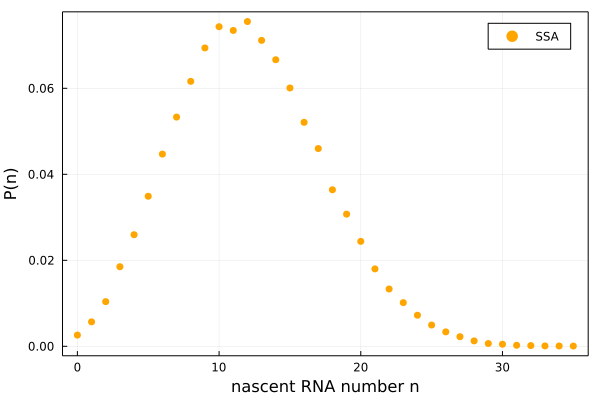

In [110]:
# plot the nascent RNA distribution

fig2=plot(PSSA[!,1],PSSA[!,2],
    seriestype=:scatter,
    xlabel="nascent RNA number n",
    ylabel="P(n)",
    framestyle=:box,
    label="SSA",
    color="orange",
    markerstrokecolor="orange")

In [52]:
# import exact data obtained by Mathematica

using CSV
using DataFrames
directory="C:\\Users\\jszav\\OneDrive\\Documents\\Research\\transcription-renewal"
filename="nascent-RNA-dist-model-2-exact.csv"

Pexact = CSV.read(string(directory,"\\",filename), DataFrame, header=false);

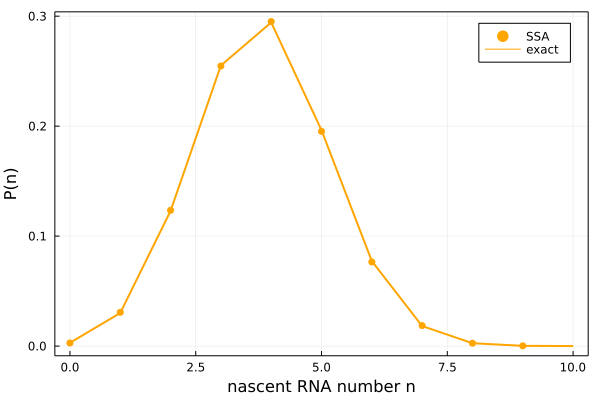

In [53]:
# add exact values to the plot

plot!(Pexact[!,1],Pexact[!,2],line=2,color="orange",label="exact")

In [ ]:
# export figure

# savefig(fig2, "nascent-RNA-dist-model-2.pdf")